# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as p
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import chain 

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [3]:
! ls

AZDIAS_Feature_Summary.csv	  terms_and_conditions
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
feat_info.csv			  Udacity_CUSTOMERS_Subset.csv
Identify_Customer_Segments.ipynb


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdiasdf = pd.read_csv('Udacity_AZDIAS_Subset.csv' , sep=";" )

In [5]:
azdias = azdiasdf.copy()

In [6]:
## print the first few rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns )
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
# Load in the feature summary file.
feat_info =  pd.read_csv('AZDIAS_Feature_Summary.csv' , error_bad_lines=False , sep=";")

In [9]:
## print the first few rows
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns )
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
stripped_miss_unok = feat_info['missing_or_unknown'].str.strip('[').str.strip(']').str.split(',').tolist()

In [13]:
#Looping through the list and change the values that matches our criteria

for index,val in enumerate(stripped_miss_unok):
       for index2,val2 in enumerate(val):
            if (val2 == ''):
                stripped_miss_unok[index][index2] = np.nan                

                

In [14]:
#Appending our change to the original dataframe
feat_info['missing_or_unknown'] = stripped_miss_unok

In [15]:
# Make the values that matches the missing or unkowns to null values
columns = azdias.columns
for index,val in enumerate(columns):
    missing_code = feat_info.loc[ feat_info['attribute'] == val ]['missing_or_unknown'].tolist()
    missing_code = list(chain.from_iterable(missing_code))
    azdias.loc[azdias[val].isin(missing_code), [val]] = np.nan

In [16]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMI

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# Investigate patterns in the amount of missing data in each column.
missing_values_after = azdias.isna().mean().round(4) * 100
missing_values_after

AGER_TYP                 76.96
ALTERSKATEGORIE_GROB      0.32
ANREDE_KZ                 0.00
CJT_GESAMTTYP             0.54
FINANZ_MINIMALIST         0.00
FINANZ_SPARER             0.00
FINANZ_VORSORGER          0.00
FINANZ_ANLEGER            0.00
FINANZ_UNAUFFAELLIGER     0.00
FINANZ_HAUSBAUER          0.00
FINANZTYP                 0.00
GEBURTSJAHR              44.02
GFK_URLAUBERTYP           0.54
GREEN_AVANTGARDE          0.00
HEALTH_TYP               12.48
LP_LEBENSPHASE_FEIN      10.95
LP_LEBENSPHASE_GROB      10.61
LP_FAMILIE_FEIN           8.73
LP_FAMILIE_GROB           8.73
LP_STATUS_FEIN            0.54
LP_STATUS_GROB            0.54
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
RETOURTYP_BK_S            0.54
SEMIO_SOZ                 0.00
SEMIO_FAM                 0.00
SEMIO_REL                 0.00
SEMIO_MAT                 0.00
SEMIO_VERT                0.00
SEMIO_LUST                0.00
SEMIO_ERL                 0.00
SEMIO_KULT                0.00
SEMIO_RA

In [18]:
# Investigate patterns in the amount of missing data in each column.
percent_missing = azdias.isnull().sum() * 100 / len(azdias)
missing_value_df = pd.DataFrame({'column_name': azdias.columns,
                                 'percent_missing': percent_missing})

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# remove columns that have more than 34% missing data 
dropped_columns = missing_value_df.loc[missing_value_df['percent_missing'] > 34 ]['column_name']
dropped_columns.tolist()

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [20]:
#Drop the data
azdias.drop(columns=dropped_columns,axis=1,inplace=True)

# Discussion 1.1.2: Assess Missing Data in Each Column


The amount of missing data in each column by percentage : 




-	AGER_TYP                 76.96
-	ALTERSKATEGORIE_GROB      0.32
-	ANREDE_KZ                 0.00
-	CJT_GESAMTTYP             0.54
-	FINANZ_MINIMALIST         0.00
-	FINANZ_SPARER             0.00
-	FINANZ_VORSORGER          0.00
-	FINANZ_ANLEGER            0.00
-	FINANZ_UNAUFFAELLIGER     0.00
-	FINANZ_HAUSBAUER          0.00
-	FINANZTYP                 0.00
-	GEBURTSJAHR              44.02
-	GFK_URLAUBERTYP           0.54
-	GREEN_AVANTGARDE          0.00
-	HEALTH_TYP               12.48
-	LP_LEBENSPHASE_FEIN      10.95
-	LP_LEBENSPHASE_GROB      10.61
-	LP_FAMILIE_FEIN           8.73
-	LP_FAMILIE_GROB           8.73
-	LP_STATUS_FEIN            0.54
-	LP_STATUS_GROB            0.54
-	NATIONALITAET_KZ         12.15
-	PRAEGENDE_JUGENDJAHRE    12.14
-	RETOURTYP_BK_S            0.54
-	SEMIO_SOZ                 0.00
-	SEMIO_FAM                 0.00
-	SEMIO_REL                 0.00
-	SEMIO_MAT                 0.00
-	SEMIO_VERT                0.00
-	SEMIO_LUST                0.00
-	SEMIO_ERL                 0.00
-	SEMIO_KULT                0.00
-	SEMIO_RAT                 0.00
-	SEMIO_KRIT                0.00
-	SEMIO_DOM                 0.00
-	SEMIO_KAEM                0.00
-	SEMIO_PFLICHT             0.00
-	SEMIO_TRADV               0.00
-	SHOPPER_TYP              12.48
-	SOHO_KZ                   8.25
-	TITEL_KZ                 99.76
-	VERS_TYP                 12.48
-	ZABEOTYP                  0.00
-	ALTER_HH                 34.81
-	ANZ_PERSONEN              8.25
-	ANZ_TITEL                 8.25
-	HH_EINKOMMEN_SCORE        2.06
-	KK_KUNDENTYP             65.60
-	W_KEIT_KIND_HH           16.61
-	WOHNDAUER_2008            8.25
-	ANZ_HAUSHALTE_AKTIV      11.18
-	ANZ_HH_TITEL             10.88
-	GEBAEUDETYP              10.45
-	KONSUMNAEHE               8.30
-	MIN_GEBAEUDEJAHR         10.45
-	OST_WEST_KZ              10.45
-	WOHNLAGE                 10.45
-	CAMEO_DEUG_2015          11.15
-	CAMEO_DEU_2015           11.15
-	CAMEO_INTL_2015          11.15
-	KBA05_ANTG1              14.96
-	KBA05_ANTG2              14.96
-	KBA05_ANTG3              14.96
-	KBA05_ANTG4              14.96
-	KBA05_BAUMAX             53.47
-	KBA05_GBZ                14.96
-	BALLRAUM                 10.52
-	EWDICHTE                 10.52
-	INNENSTADT               10.52
-	GEBAEUDETYP_RASTER       10.45
-	KKK                      17.74
-	MOBI_REGIO               14.96
-	ONLINE_AFFINITAET         0.54
-	REGIOTYP                 17.74
-	KBA13_ANZAHL_PKW         11.87
-	PLZ8_ANTG1               13.07
-	PLZ8_ANTG2               13.07
-	PLZ8_ANTG3               13.07
-	PLZ8_ANTG4               13.07
-	PLZ8_BAUMAX              13.07
-	PLZ8_HHZ                 13.07
-	PLZ8_GBZ                 13.07
-	ARBEIT                   10.93
-	ORTSGR_KLS9              10.91
-	RELAT_AB                 10.93

Which columns were removed from the dataset?

Remove columns that have more than 34% of missing data 

-	AGER_TYP                 76.96
-	GEBURTSJAHR              44.02
-	TITEL_KZ                 99.76
-	ALTER_HH                 34.81 
-	KK_KUNDENTYP             65.60
-	KBA05_BAUMAX             53.47


     





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
azdias['row_missing_values'] = azdias.apply(lambda x: x.count(), axis=1)

In [22]:
azdias['row_missing_values'] = (azdias['row_missing_values'] - 79)* -1

In [23]:
azdias['row_missing_values'] = (azdias['row_missing_values'] / 79)*100

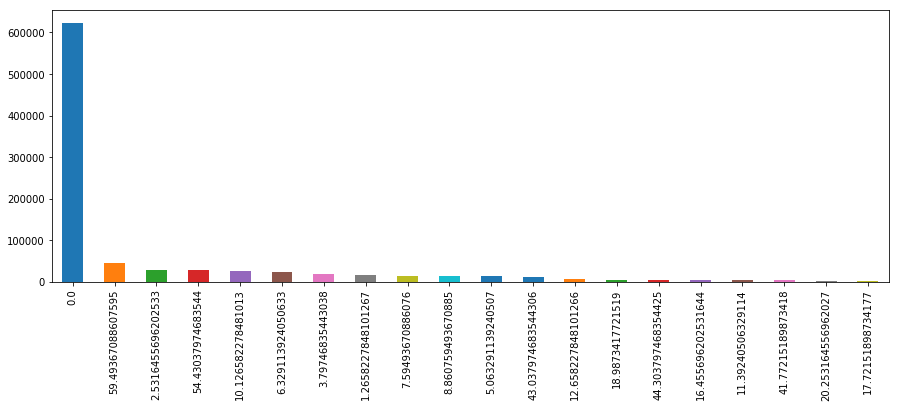

In [24]:
azdias.row_missing_values.value_counts().nlargest(20).plot(kind='bar', stacked=True, figsize=(15, 5))

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

BelowThreshold = azdias.loc[azdias.isnull().sum(axis=1) >= 30]
AboveThreshold = azdias.loc[azdias.isnull().sum(axis=1) < 30]

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# we select a 5  columns
random_col = ['ANREDE_KZ','SEMIO_SOZ','SEMIO_VERT','SEMIO_KRIT','SEMIO_PFLICHT']


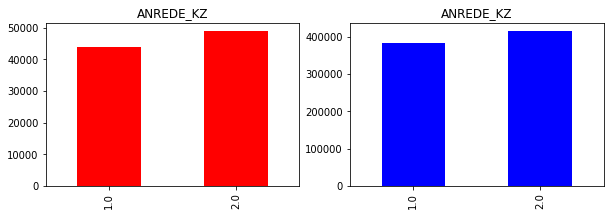

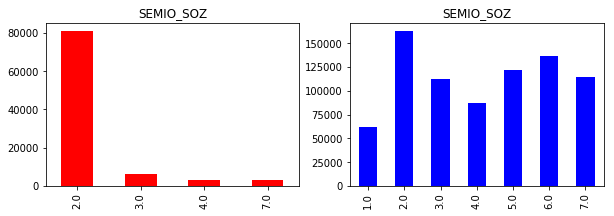

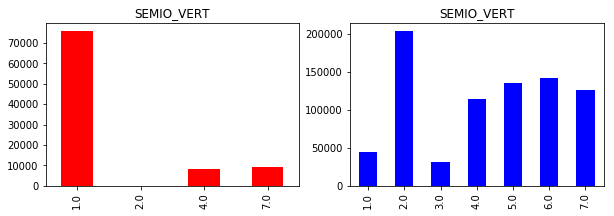

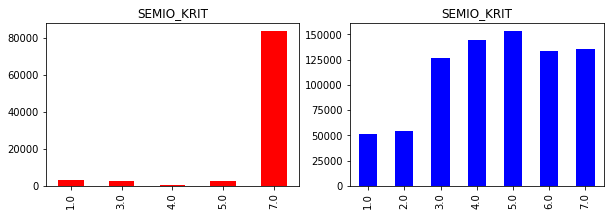

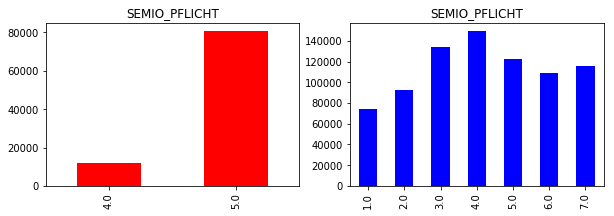

In [27]:
for i in random_col:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    BelowThreshold[i].value_counts().sort_index().plot.bar(color = 'r',title = i)
    plt.subplot(1,2,2)
    AboveThreshold[i].value_counts().sort_index().plot.bar(color = 'b',title = i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distributions of values between the two datasets are quite differen as we can see in the high missing dataset less types than low missing dataset but "ANDREDE_KZ" it,s similar in both dataset 


In [28]:
# drop rows that conider as Below Threshold 
#azdias  = AboveThreshold 

In [29]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_missing_values
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.430380
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000


In [30]:
# after assess missing value i will delete column "row_missing_values" 
del azdias['row_missing_values']

In [31]:
# to check  
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
! ls 

AZDIAS_Feature_Summary.csv	  terms_and_conditions
Data_Dictionary.md		  Udacity_AZDIAS_Subset.csv
feat_info.csv			  Udacity_CUSTOMERS_Subset.csv
Identify_Customer_Segments.ipynb


In [33]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [34]:
# I will delete the six attributes that we have deleted previously

#	AGER_TYP                 
#	GEBURTSJAHR              
#	TITEL_KZ                 
#	ALTER_HH                 
#	KK_KUNDENTYP             
#	KBA05_BAUMAX     


feat_info_cleaned = feat_info[(feat_info['attribute'] !='AGER_TYP') & (feat_info['attribute'] != 'GEBURTSJAHR') & (feat_info['attribute'] != 'TITEL_KZ') & 
                              (feat_info['attribute'] != 'ALTER_HH') & (feat_info['attribute'] != 'KK_KUNDENTYP') & (feat_info['attribute'] != 'KBA05_BAUMAX')]

In [35]:
# How many features are there of each data type?

feat_info_cleaned.type.value_counts()


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info_cleaned.query('type == "categorical"')['attribute']
categorical_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Binary categorical varible : 
binary = []
# Multi level categorical varible : 
multiple = []
for i in categorical_features:
    if (azdias[i].nunique() == 2 ):
        binary.append(i)
    elif(azdias[i].nunique() > 2):
        multiple.append(i)

In [38]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [39]:
multiple

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [40]:
azdias['OST_WEST_KZ'].head()

0    NaN
1      W
2      W
3      W
4      W
Name: OST_WEST_KZ, dtype: object

In [41]:
# OST_WEST_KZ coulmns need convert to number to enable us to handle it as 'binary' 
azdias['OST_WEST_KZ'].replace({'W': 0, 'O': 1},inplace=True)

In [42]:
# my approach to keep all binay varilables and drop all multiple varilables 
azdias.drop(columns=multiple,axis=1,inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

My approach to keep all binay varilables and drop all multiple varilables
- I start with separated categories to binary and multiple 
- then i find one of binary varible need convert to number to enable us to handle it as binary 
- than i drop all multiple varilbles . 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [43]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts() 


14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [44]:
#Creating two features of decade and movment 
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['movment'] = azdias['PRAEGENDE_JUGENDJAHRE']

In [45]:
#Map decade  

# this info from Data_Dictionary.md
azdias['decade'].replace({1:1,
                          2:1,
                          3:2,
                          4:2,
                          5:3,
                          6:3,
                          7:3,
                          8:4,
                          9:4,
                          10:5,
                          11:5,
                          12:5,
                          13:5,
                          14:6,
                          15:6},
                         inplace=True)

In [46]:
azdias['movment'].replace({1:1
                           ,2:0
                           ,3:1
                           ,4:0
                           ,5:1
                           ,6:0
                           ,7:0
                           ,8:1
                           ,9:0
                           ,10:1
                           ,11:0
                           ,12:1
                           ,13:0
                           ,14:1
                           ,15:0},
                          inplace=True)

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)
# value count
azdias['CAMEO_INTL_2015'].value_counts() 

51.0    133694
41.0     92336
24.0     91158
14.0     62884
43.0     56672
54.0     45391
25.0     39628
22.0     33155
23.0     26750
13.0     26336
45.0     26132
55.0     23955
52.0     20542
31.0     19024
34.0     18524
15.0     16974
44.0     14820
12.0     13249
35.0     10356
32.0     10354
33.0      9935
Name: CAMEO_INTL_2015, dtype: int64

In [48]:
#Creating two features of wealth and laife stage 
azdias['wealth'] = azdias['CAMEO_INTL_2015']
azdias['lifeStage'] = azdias['CAMEO_INTL_2015']

In [49]:
#Map wealth  

# this info from Data_Dictionary.md
azdias['wealth'].replace({11:1
                          ,12:1
                          ,13:1
                          ,14:1
                          ,15:1
                          ,21:2
                          ,22:2
                          ,23:2
                          ,24:2
                          ,25:2
                          ,31:3
                          ,32:3
                          ,33:3
                          ,34:3
                          ,35:3
                          ,41:4
                          ,42:4
                          ,43:4
                          ,44:4
                          ,45:4
                          ,51:5
                          ,52:5
                          ,53:5
                          ,54:5
                          ,55:5}
                         ,inplace=True)

In [50]:
azdias['wealth'].value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: wealth, dtype: int64

In [51]:
#Map lifeStage 

# this info from Data_Dictionary.md

azdias['lifeStage'].replace({11:1,
                             12:2,
                             13:3,
                             14:4,
                             15:5,
                             21:1,
                             22:2,
                             23:3,
                             24:4,
                             25:5,
                             31:1,
                             32:2,
                             33:3,
                             34:4,
                             35:5,
                             41:1,
                             42:2,
                             43:3,
                             44:4,
                             45:5,
                             51:1,
                             52:2,
                             53:3,
                             54:4,
                             55:5},
                            inplace=True)

In [52]:
azdias['lifeStage'].value_counts()

1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: lifeStage, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features


- Created four new features columns, where I kept these two mixed-value features:

-  PRAEGENDE_JUGENDJAHRE
-  CAMEO_INTL_2015

- where i have copied the values from the initial mixed-value feature column Performed a replace operation.

- I will drop the other four mixed-values features In the next step 1.2.3.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_features = feat_info_cleaned.query('type == "mixed"')['attribute'].tolist()
azdias.drop(columns=mixed_features,axis=1,inplace=True)

In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movment,wealth,lifeStage
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [55]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null float64
SEMIO_FAM                891221 non-null float64
SEMIO_REL                891221 non-null float64
SEMIO_MAT                891221 non-null float64
SEMIO_VERT               891221 non-null float64
SEMIO_LUST               891221 non-null float64
SEMIO_ERL                891221 non-null float64
SEMIO_K

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    stripped_miss_unok = feat_info['missing_or_unknown'].str.strip('[').str.strip(']').str.split(',').tolist()
    for index,val in enumerate(stripped_miss_unok):
        for index2,val2 in enumerate(val):
            if (val2 == ''):
                stripped_miss_unok[index][index2] = np.nan                               
#Appending our change to the original dataframe
    feat_info['missing_or_unknown'] = stripped_miss_unok
    
    
    columns = df.columns
    for index,val in enumerate(columns):
        missing_code = feat_info.loc[ feat_info['attribute'] == val ]['missing_or_unknown'].tolist()
        missing_code = list(chain.from_iterable(missing_code))
        df.loc[df[val].isin(missing_code), [val]] = np.nan
    
    # select, re-encode, and engineer column values.
    # Investigate patterns in the amount of missing data in each column.
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
# Remove the outlier columns from the dataset.
    
    dropped_columns = missing_value_df.loc[missing_value_df['percent_missing'] > 34 ]['column_name'].tolist()
    keeped_col = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','OST_WEST_KZ']
    for col in keeped_col:
        if col in dropped_columns: 
            dropped_columns.remove(col)
            indexNames = feat_info[ feat_info['attribute'] == col ].index
            # Delete these row indexes from dataFrame
            feat_info.drop(indexNames , inplace=True)
    df.drop(columns=dropped_columns,axis=1,inplace=True)
    
    #Update feat_info
    for col in dropped_columns:
        indexNames = feat_info[ feat_info['attribute'] == col ].index
        # Delete these row indexes from dataFrame
        feat_info.drop(indexNames , inplace=True)
    
# Creating two features of decade and movment 
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['movment'] = df['PRAEGENDE_JUGENDJAHRE']
#Map decade  
    df['decade'].replace({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6},inplace=True)
#Map movment  
    df['movment'].replace({1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0},inplace=True)
#Convert to float so i can replace them with numbers 
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
#Creating two features of wealth and laife stage 
    df['wealth'] = df['CAMEO_INTL_2015']
    df['lifeStage'] = df['CAMEO_INTL_2015']
#Map wealth  
    df['wealth'].replace({11:1,12:1,13:1,14:1,15:1,21:2,22:2,23:2,24:2,25:2,31:3,32:3,33:3,34:3,35:3,41:4,42:4,43:4,44:4,45:4,51:5,52:5,53:5,54:5,55:5},inplace=True)
#Map lifeStage  
    df['lifeStage'].replace({11:1,12:2,13:3,14:4,15:5,21:1,22:2,23:3,24:4,25:5,31:1,32:2,33:3,34:4,35:5,41:1,42:2,43:3,44:4,45:5,51:1,52:2,53:3,54:4,55:5},inplace=True)
# Re-encode categorical variable(s) to be kept in the analysis.
    df['OST_WEST_KZ'].replace({'W': 0, 'O': 1},inplace=True)
# Drop multi-level features
    categorical_features = feat_info.query('type == "categorical"')['attribute']
    multi = []
    for i in categorical_features:
        if(df[i].nunique() > 2):
            multi.append(i)
    df.drop(columns=multi,axis=1,inplace=True)

# Remove mixed categorical variables

    mixed_features = feat_info.query('type == "mixed"')['attribute'].tolist()
    df.drop(columns=mixed_features,axis=1,inplace=True)

    # remove selected columns and rows, ...

#Drop null values
    df.dropna(how='any',axis=0,inplace=True) 
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
azdias.shape

(891221, 64)

In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# As you recommended, I will use an imputer instead of dropping all nulls.

fill_missing = Imputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(fill_missing.fit_transform(azdias))

In [59]:
azdias_clean_imputed.columns = azdias.columns
azdias_clean_imputed.index = azdias.index

In [60]:
from sklearn.preprocessing import StandardScaler

# Apply feature scaling to the general population demographics data.

#scale data

#define scaler function:
scaler = StandardScaler() 
#fit dataset to scaler function:
azdias_ss = scaler.fit_transform(azdias_clean_imputed)


In [61]:
azdias_ss.shape 

(891221, 64)

In [62]:
#transform dataset:
azdias_ss = pd.DataFrame(azdias_ss, columns=list(azdias_clean_imputed))

In [63]:
azdias_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movment,wealth,lifeStage
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,1.107928,-0.999639,0.901553,1.374629,0.537487,-1.455284,0.316841,-0.819565,-0.538400,0.056863,1.221756,0.742018,0.839442,0.420264,-0.387544,-0.088255,0.864739,-0.593390,-0.057885,-1.379075,0.873364,0.536436,-0.436907,-0.118316,-1.167350,-0.359845,-0.482932,-0.907602,-0.872303,-0.552796,-0.434299,-0.109875,0.771572,1.056974,0.209499,0.267123,0.254254,-1.118995,-1.116346,0.712197,1.689863,-0.241920,0.200128,0.378140,-0.846764,-0.572015,-0.317206,0.758890,-0.120115,-0.049267,0.994991,0.494701,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,-1.711653,0.541539,-0.142352,-0.119863,-0.539206,-1.455284,-1.166231,-1.372799,-0.538400,1.322441,-0.416882,1.298900,-0.240231,1.550121,1.369271,11.330820,0.864739,0.295412,-0.057885,1.079004,-0.822280,0.536436,0.231876,-0.118316,-1.167350,-0.359845,-0.482932,-0.907602,-0.872303,-0.552796,2.904396,-1.739380,0.771572,-0.662553,1.768571,-0.872772,-0.863071,-1.118995,0.200965,-0.987654,0.615985,-0.241920,0.200128,0.378140,0.546491,1.575581,0.640354,-0.263506,-0.120115,0.729399,0.994991,0.494701,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,-0.301862,0.027813,-1.708208,-0.618027,-0.539206,-0.011411,-0.177517,0.840140,-0.538400,0.056863,1.221756,1.298900,1.379279,-0.709593,-0.387544,-0.088255,-1.156419,-0.593390,-0.057885,-0.150036,-0.822280,0.536436,0.164998,-0.118316,1.355387,-0.359845,-0.482932,-0.193370,1.559191,0.488058,-0.434299,-0.109875,-1.095860,-0.089377,-0.310191,0.267123,-0.863071,0.221279,-0.457690,-1.554272,-0.000819,0.856668,0.200128,-0.697094,-0.846764,0.501783,0.640354,-0.263506,-0.120115,-0.827934,0.994991,-2.021423,-0.980453,0.879581
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,-1.006758,0.541539,-1.708208,-1.116191,-1.615900,-0.011411,-0.177517,1.393374,-0.013139,-0.575926,-0.416882,-0.371747,0.299605,-0.144664,0.198061,-0.088255,-1.156419,-1.482193,-0.057885,-1.993595,0.873364,0.536436,-0.436907,-0.118316,0.724703,1.213535,-0.482932,1.949328,-0.061805,-0.552796,-0.434299,0.704878,-0.162144,-1.235729,0.729190,0.267123,0.254254,0.891416,-1.116346,0.712197,-0.285876,-0.241920,-0.961799,0.378140,-0.846764,-0.572015,0.640354,-1.285903,-1.039247,-0.049267,-0.363493,0.494701,-1.653917,-0.437384
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,1.107928,1.055265,-0.142352,-0.119863,-1.077553,1.432462,-0.177517,-0.266330,1.037383,-1.208715,-0.963095,-1.485512,-1.319905,-0.144664,-0.973149,-0.088255,0.864739,2.073018,-0.057885,0.464484,-1.387495,0.536436,-0.303151,-0.118316,0.724703,-0.359845,-0.482932,-0.193370,2.369689,0.488058,-0.434299,-0.109875,-1.095860,0.483799,-1.869263,1.407019,0.254254,0.221279,1.518276,0.145580,-0.681516,-0.241920,1.362055,0.378140,0.546491,-0.572015,-0.317206,0.758890,0.339451,1.508065,-0.363493,0.494701,0.366474,0.221098


## Discussion 2.1: Apply Feature Scaling

- As you recommended, I used an imputer instead to dropping all nulls Then fit the StandardScaler transformation to this dataset.



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [64]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
# fit for the PCA 
pca.fit(azdias_ss)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

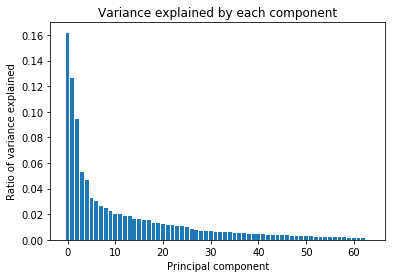

In [65]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

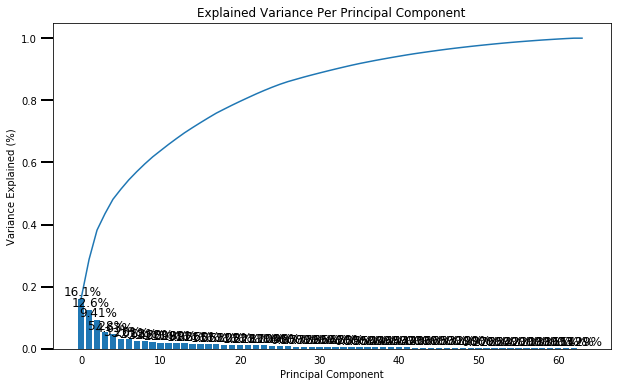

In [66]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


scree_plot(pca)

In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_25 = PCA(n_components=25)
azdias_pca = pca_25.fit_transform(azdias_ss)


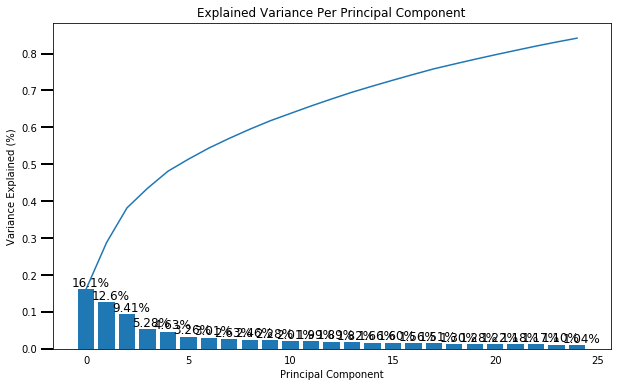

In [68]:
scree_plot(pca_25)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 25 principal components, as it expalains more than 88% variances while reducing the number of features

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells. 
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_ss.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights    

In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_weights(pca_25,0))



PLZ8_ANTG3               0.219325
wealth                   0.207048
EWDICHTE                 0.195911
FINANZ_SPARER            0.182843
ORTSGR_KLS9              0.179124
PLZ8_ANTG4               0.170472
PLZ8_ANTG2               0.149971
SEMIO_REL                0.149043
decade                   0.147873
ARBEIT                   0.147302
SEMIO_PFLICHT            0.145788
HH_EINKOMMEN_SCORE       0.142437
FINANZ_HAUSBAUER         0.141206
KBA05_ANTG4              0.130378
FINANZ_UNAUFFAELLIGER    0.124780
RELAT_AB                 0.124307
movment                  0.120360
SEMIO_RAT                0.119813
FINANZ_ANLEGER           0.119356
ANZ_HAUSHALTE_AKTIV      0.112864
KBA05_ANTG3              0.111560
SEMIO_MAT                0.100044
SEMIO_TRADV              0.099779
SEMIO_FAM                0.097051
REGIOTYP                 0.077568
HEALTH_TYP               0.067327
SEMIO_KAEM               0.065451
SEMIO_KULT               0.061875
VERS_TYP                 0.049748
SEMIO_DOM     

In [71]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca_25,1))

ALTERSKATEGORIE_GROB     0.245440
FINANZ_VORSORGER         0.224751
SEMIO_ERL                0.213216
SEMIO_LUST               0.169183
RETOURTYP_BK_S           0.166745
FINANZ_HAUSBAUER         0.143149
PLZ8_ANTG4               0.140492
ORTSGR_KLS9              0.131264
PLZ8_ANTG3               0.126730
KBA05_ANTG4              0.105898
W_KEIT_KIND_HH           0.104322
EWDICHTE                 0.103013
HH_EINKOMMEN_SCORE       0.099840
ANZ_HAUSHALTE_AKTIV      0.095430
RELAT_AB                 0.091666
PLZ8_ANTG2               0.088326
wealth                   0.083154
SEMIO_KAEM               0.079358
ARBEIT                   0.078821
KBA05_ANTG3              0.078598
SEMIO_KRIT               0.069993
ANREDE_KZ                0.064983
OST_WEST_KZ              0.045435
WOHNDAUER_2008           0.043346
SEMIO_DOM                0.042426
ANZ_HH_TITEL             0.041402
FINANZ_MINIMALIST        0.040614
PLZ8_HHZ                 0.031736
VERS_TYP                 0.020153
movment       

In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca_25,2))



SEMIO_VERT               0.347088
SEMIO_SOZ                0.297649
SEMIO_KULT               0.288351
SEMIO_FAM                0.227314
PLZ8_ANTG4               0.107253
FINANZ_MINIMALIST        0.089509
SEMIO_MAT                0.075576
ORTSGR_KLS9              0.075502
RETOURTYP_BK_S           0.069774
HH_EINKOMMEN_SCORE       0.062864
KBA05_ANTG4              0.062380
ANZ_HAUSHALTE_AKTIV      0.061015
SEMIO_REL                0.059616
GREEN_AVANTGARDE         0.055332
PLZ8_ANTG3               0.052369
KBA05_ANTG3              0.051242
OST_WEST_KZ              0.048927
RELAT_AB                 0.046396
FINANZ_VORSORGER         0.040217
KBA05_ANTG2              0.036052
PLZ8_ANTG2               0.034776
PLZ8_HHZ                 0.031629
lifeStage                0.027319
ANZ_HH_TITEL             0.022932
ANZ_PERSONEN             0.021360
ALTERSKATEGORIE_GROB     0.018620
EWDICHTE                 0.016054
ARBEIT                   0.015289
W_KEIT_KIND_HH           0.013074
ANZ_TITEL     

In [73]:
def pca_results(good_data, pca):

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movment,wealth,lifeStage
Dimension 1,0.1618,-0.1481,0.0182,-0.2251,0.1828,-0.1428,0.1194,0.1248,0.1412,-0.1204,0.0673,-0.0399,0.0095,0.0971,0.1490,0.1000,-0.0792,-0.0826,-0.1011,0.0619,0.1198,0.0390,0.0491,0.0655,0.1458,0.0998,-0.0041,0.0497,-0.0855,-0.0066,0.1424,0.0466,-0.0507,0.1129,0.0264,-0.1728,-0.0450,0.0343,-0.2162,-0.0108,0.1116,0.1304,-0.2053,-0.0924,0.1959,-0.1465,-0.1014,0.0471,-0.2252,-0.0324,0.0776,-0.0084,-0.2167,0.1500,0.2193,0.1705,0.0265,-0.1601,0.1473,0.1791,0.1243,0.1479,0.1204,0.2070,-0.1421
Dimension 2,0.1261,0.2454,0.0650,0.0406,-0.2257,0.2248,-0.2114,-0.2228,0.1431,-0.0188,-0.0694,0.1667,-0.0578,-0.1650,-0.2336,-0.1544,-0.0234,0.1692,0.2132,-0.1814,-0.1713,0.0700,0.0424,0.0794,-0.2208,-0.2151,-0.0005,0.0202,-0.0620,0.0085,0.0998,0.1043,0.0433,0.0954,0.0414,-0.0742,-0.0517,0.0454,-0.0844,0.0149,0.0786,0.1059,-0.1231,-0.0973,0.1030,-0.1111,-0.0713,-0.0016,-0.0856,-0.1667,0.0042,-0.0700,-0.1278,0.0883,0.1267,0.1405,0.0317,-0.0966,0.0788,0.1313,0.0917,-0.2363,0.0188,0.0832,0.0031
Dimension 3,0.0942,0.0186,-0.3402,0.0895,-0.0619,0.0402,-0.1707,-0.0971,-0.0206,0.0553,-0.0629,0.0698,0.2976,0.2273,0.0596,0.0756,0.3471,-0.0025,-0.1788,0.2884,-0.1510,-0.3109,-0.3188,-0.3447,-0.0283,0.0068,0.0046,-0.0474,0.0214,0.0108,0.0629,0.0131,-0.0163,0.0610,0.0229,-0.0001,-0.0061,0.0489,-0.0018,0.0361,0.0512,0.0624,-0.0453,-0.0853,0.0161,-0.0727,-0.0573,-0.0268,0.0043,-0.0099,-0.0404,-0.1036,-0.0608,0.0348,0.0524,0.1073,0.0316,-0.0468,0.0153,0.0755,0.0464,-0.0794,-0.0553,-0.0031,0.0273
Dimension 4,0.0528,-0.0903,0.1484,-0.0751,0.0242,-0.0851,-0.0896,-0.0215,0.0051,0.3189,-0.0719,-0.0687,0.0355,-0.1380,-0.0815,-0.0189,-0.0097,-0.0853,0.0633,-0.0171,0.1590,-0.0377,0.1298,0.0942,0.0538,0.1710,0.0110,-0.0787,0.1576,0.0408,-0.0278,-0.2178,-0.0658,0.0532,0.0572,-0.0026,-0.0269,0.0243,0.1378,0.0928,0.0200,0.0389,0.0286,-0.2573,0.0881,-0.1996,-0.1054,-0.2424,0.1387,0.1813,-0.2553,-0.1803,-0.0354,0.0451,0.0486,0.1675,0.1100,-0.0040,-0.0092,0.2125,0.0803,0.0174,-0.3189,-0.1760,0.1602
Dimension 5,0.0463,-0.0285,0.1144,-0.1788,0.0149,-0.0692,0.0529,-0.1572,0.1633,-0.2529,-0.1358,-0.0851,0.0500,-0.1414,-0.1118,-0.0425,0.0463,-0.1182,0.1189,0.0386,0.1052,-0.0906,-0.0404,-0.0175,0.0257,0.1136,0.0124,-0.1636,0.0507,-0.0276,0.3317,-0.1392,-0.1085,0.1301,0.0207,0.2335,0.0460,0.2295,0.0049,0.0773,0.1362,0.1180,-0.0701,0.0397,-0.2781,0.1016,0.0058,0.1464,0.0554,0.0223,0.0253,-0.2921,0.0248,-0.1271,-0.0915,0.0945,-0.0992,-0.0890,-0.0875,-0.1326,-0.0605,-0.0380,0.2529,-0.0326,0.1143
Dimension 6,0.0326,-0.0203,0.0258,-0.1463,0.0056,0.0472,-0.0503,0.0048,0.1700,-0.0592,-0.0516,0.0188,0.0162,0.0144,0.0012,0.0752,-0.0025,0.0198,-0.0133,-0.0170,0.0497,-0.0165,-0.0101,-0.0484,0.0112,0.0775,-0.0007,-0.0411,-0.1538,0.0268,0.0996,0.1252,-0.0678,0.1367,0.1156,-0.0880,-0.0926,-0.1526,-0.0627,0.1025,0.0628,0.1007,-0.1209,0.0299,-0.1047,0.0954,-0.1306,-0.2675,-0.0656,-0.1316,-0.2404,0.3022,0.0504,0.0351,-0.0186,0.0178,0.4290,0.3556,-0.2865,-0.1291,-0.2132,-0.0362,0.0592,-0.0407,0.0440
Dimension 7,0.0301,0.0258,-0.0220,0.0563,0.0117,-0.0363,0.0315,0.0374,-0.1089,0.0410,0.0344,0.0016,-0.0143,0.0187,-0.0034,-0.0269,0.0034,0.0207,-0.0089,-0.0495,-0.0451,0.0330,-0.0123,0.0019,-0.0477,-0.0458,-0.0023,0.0216

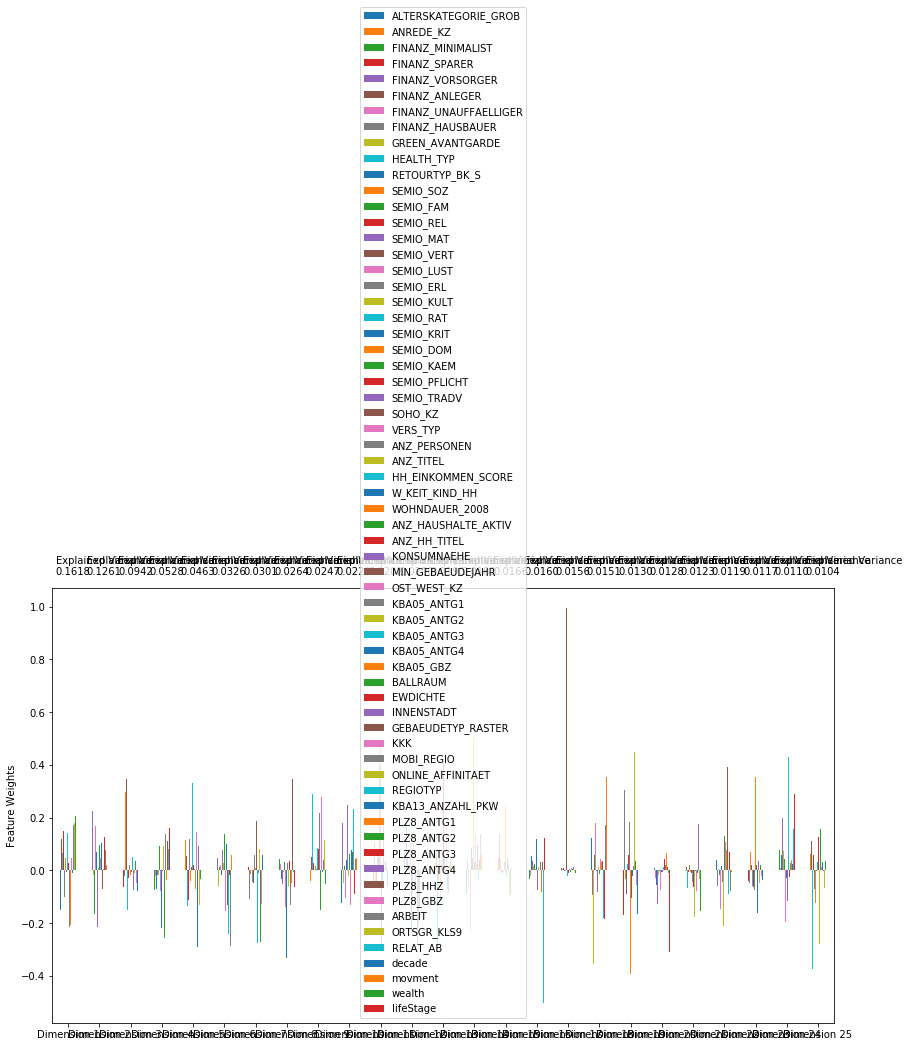

In [74]:
pca_results(azdias,pca_25)

In [75]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null float64
SEMIO_FAM                891221 non-null float64
SEMIO_REL                891221 non-null float64
SEMIO_MAT                891221 non-null float64
SEMIO_VERT               891221 non-null float64
SEMIO_LUST               891221 non-null float64
SEMIO_ERL                891221 non-null float64
SEMIO_K

### Discussion 2.3: Interpret Principal Components

we can say: PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation. The share of 10 family homes and the share of 6 family homes to 10 family home for macro-cells tend to increase together.
MOBI_REGIO and PLZ8_ANTG3 have a negative correlation. It means that when the share of 6-10 family homes in a macro-cell increases, it tends to have higher movements

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

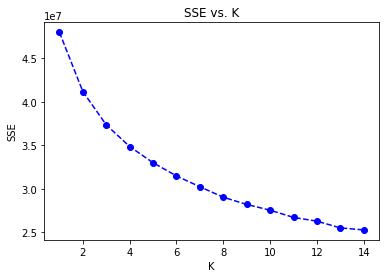

In [76]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...  
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,15))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');    

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 7)
model_7 = kmeans.fit(azdias_pca)
azdias_pred = model_7.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Into how many clusters have you decided to segment the population?  

According to these observations, it’s possible to define k = 7 as the optimal number of clusters in the data.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [ ]:
customers.head()

In [ ]:
customers.shape

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
customers_clean = clean_data(customers)

In [ ]:
# after cleaning 
customers_clean.shape

In [ ]:
customers_clean_imputed = fill_missing.transform(customers_clean)

standardized_customers = scaler.transform(customers_clean_imputed)

customers_pca = pca_25.transform(standardized_customers)

customers_pred = model_7.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
#plotting 
# Plot the original data with clusters
plt.scatter(customers_pca[:,0], customers_pca[:,1], c=customers_pred, cmap='Set1');

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('Demographics Clusters')


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_6 = scaler.inverse_transform(pca_25.inverse_transform(model_7.cluster_centers_[6]))

pd.Series(data =centroid_6, index = customers_clean.columns)


In [ ]:
# What kinds of people are part of a cluster that is  overrepresented in the
# customer data compared to the general population?
centroid_2 = scaler.inverse_transform(pca_25.inverse_transform(model_7.cluster_centers_[2]))
pd.Series(data =centroid_2, index = customers_clean.columns)


In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(ax=ax, x=customers_clean.columns[61:64], y =centroid_6[61:64])
ax.set_xlabel('cluster')
ax.set_title('Proportions per cluster for general vs customer populations');

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(ax=ax, x=customers_clean.columns[61:64], y =centroid_2[61:64])
ax.set_xlabel('cluster')
ax.set_title('Proportions per cluster for general vs customer populations');

### Discussion 3.3: Compare Customer Data to Demographics Data

 - From the anaylsis above, it can be seen that
 

- Cluster 6 : 

- in Prosperous or Comfortable households(WEALTH=4.179667)
- in life stage of Families With School Age Children or Older Families & Mature Couples (LIFE_STAGE=2.671910)
- in movment = 0.924965

 - So we can say Cluster 6 is overrepresented in the customers data compared to general population data.

 - Cluster 2 :  

-  in Less Affluent or Poorer households(WEALTH=2.327809)
-  in life stage of Pre-Family Couples & Singles or Young Couples With Children (LIFE_STAGE=3.392023)
-  in movment = 0.615719


 -  So we can say Cluster 2 is underrepresented in the customers data compared to general population data.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.